# midinet2モデルの学習
midinet2は楽曲のより詳細な情報を条件として受け入れられるようにしたmidinetベースの音楽生成GAN

In [1]:
import os, glob, ipdb, platform, pickle, numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from PIL import Image
import pretty_midi
from pypianoroll import Multitrack, Track
from utils import grid_plot, Timer
from IPython.display import clear_output, Audio
from scipy.io import wavfile as spw
from pydub import AudioSegment as AS

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
output_dir = f"{base_dir}/learning"

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## DataLoaderの作成

In [3]:
class MidinetDataloader():
    def __init__(self, data_path, pitch_range=[0, 64], show_shape=False):
        data = pickle.load(open(data_path,'rb'))
        
        melody, prev, chord = [], [], []
        for m, p, c in data:
            melody.append(m)
            prev.append(p)
            chord.append(c)
        
        self.size = len(melody)
        steps = len(melody[0])
        bottom, top = pitch_range
        
        melody = np.array(melody)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        prev = np.array(prev)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        chord = np.array(chord)
        
        if show_shape:
            print("melody shape", melody.shape)
            print("prev shape", prev.shape)
            print("condition shape", chord.shape)
        
        self.x = torch.from_numpy(melody).float()
        self.prev_x   = torch.from_numpy(prev).float()
        self.y  = torch.from_numpy(chord).float()

    def __getitem__(self, index):
        return self.x[index], self.prev_x[index], self.y[index]

    def __len__(self):
        return self.size

In [4]:
def get_dataloader(data_path, batch_size=72, shuffle=True):
    iterator = MidinetDataloader(data_path)
    kwargs = {'num_workers': 4, 'pin_memory': True}
    data_loader = DataLoader(iterator, batch_size=batch_size, shuffle=shuffle, **kwargs)
    print('Data loading is completed.')
    print(f'{len(data_loader)} batches from {len(iterator)} bars are obtained.')
    return data_loader

In [5]:
def to_device(data):
    if not isinstance(data, torch.Tensor):
        data = torch.from_numpy(data)
    if torch.cuda.is_available():
        return data.cuda()
    return data.cpu()

## Modelの作成

#### model用共通関数の作成

In [6]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)
    
def batch_norm(x, eps=1e-05, momentum=0.9, affine=True):
    if x.ndim == 2:
        return nn.BatchNorm1d(x.shape[1], eps=eps, momentum=momentum, affine=affine).cuda()(x)
    elif x.ndim == 3:
        return nn.BatchNorm2d(x.shape[1], eps=eps, momentum=momentum, affine=affine).cuda()(x)
    else:
        return x

def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

#### Generator
ここからが本題.モデルの入力を変えたい  

forwardの入力
- z (batch, noise_size) = (72, 100): ランダムノイズ
- prev_x (batch, ch, steps, pitch) = (72, 1, 48, 64): 前の小節
- condition (batch, 54): 最初の12次元×4は拍ごとの和音, 最後の6次元はセクション

forwardの出力
- g_x (batch, ch, steps, pitch)= (72, 1, 48, 64): 生成された今の小節

畳み込みを1段階増やす  
おそらく三連譜が出てくるのは1/12分音符として使われるのが一般的だろうと踏んで，12->4のところでカーネルサイズを変更  
prev_x -> ピッチ畳み込み -> 48 -> 24 -> 12 -> 4 -> 2 -> 1  
ノイズ増やした方がいいかな？  
あとなんでストライドが縦に2なのか？最初にpitch方向は1に潰してるから関係ないと思うけど

In [7]:
class Generator(nn.Module):
    def __init__(self, nz=100, pitch_range=64):
        super(Generator, self).__init__()
        self.gf_dim  = 128
        self.y_dim   = 54
        self.nz      = nz

        self.h1      = nn.ConvTranspose2d(in_channels=198, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h2      = nn.ConvTranspose2d(in_channels=134, out_channels=pitch_range, kernel_size=(3,1), stride=(3,2))
        self.h3      = nn.ConvTranspose2d(in_channels=134, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h4      = nn.ConvTranspose2d(in_channels=134, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h5      = nn.ConvTranspose2d(in_channels=134, out_channels=1, kernel_size=(1,pitch_range), stride=(1,2))

        self.h0_prev = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1,pitch_range), stride=(1,2))
        self.h1_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))
        self.h2_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))
        self.h3_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,1), stride=(3,2))
        self.h4_prev = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2,1), stride=(2,2))

        self.linear1 = nn.Linear(self.nz + self.y_dim, 1024)
        self.linear2 = nn.Linear(1024 + self.y_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y, batch_size):
        
        h0_prev = lrelu(batch_norm(self.h0_prev(prev_x)))   # 72, 16, 48, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(batch_norm(self.h1_prev(h0_prev)))  # 72, 16, 24, 1
        h2_prev = lrelu(batch_norm(self.h2_prev(h1_prev)))  # 72, 16, 12, 1
        h3_prev = lrelu(batch_norm(self.h3_prev(h2_prev)))  # 72, 16, 4, 1
        h4_prev = lrelu(batch_norm(self.h4_prev(h3_prev)))  # 72, 16, 2, 1

        yb = y.view(batch_size, self.y_dim, 1, 1)           # 72, 54, 1, 1

        z = torch.cat((z,y),1)                              # 72, 154

        h0 = F.relu(batch_norm(self.linear1(z)))            # 72, 1024
        h0 = torch.cat((h0,y),1)                            # 72, 1078

        h1 = F.relu(batch_norm(self.linear2(h0)))           # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)         # 72, 128, 2, 1
        
        h1 = concat_vector(h1, yb)                          # 72, 182, 2, 1
        h1 = concat_vector(h1, h4_prev)                     # 72, 198, 2, 1

        h2 = F.relu(batch_norm(self.h1(h1)))                # 72,  64, 4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, yb)                          # 72, 118, 4, 1
        h2 = concat_vector(h2, h3_prev)                     # 72, 134, 4, 1

        h3 = F.relu(batch_norm(self.h2(h2)))                # 72,  64, 12, 1 
        h3 = concat_vector(h3, yb)                          # 72, 118, 12, 1
        h3 = concat_vector(h3, h2_prev)                     # 72, 134, 12, 1

        h4 = F.relu(batch_norm(self.h3(h3)))                # 72,  64, 24, 1
        h4 = concat_vector(h4, yb)                          # 72, 118, 24, 1
        h4 = concat_vector(h4, h1_prev)                     # 72, 134, 24, 1
        
        h5 = F.relu(batch_norm(self.h4(h4)))                # 72,  64, 48, 1
        h5 = concat_vector(h5, yb)                          # 72, 118, 48, 1
        h5 = concat_vector(h5, h0_prev)                     # 72, 134, 48, 1

        g_x = torch.sigmoid(self.h5(h5))                    # 72, 1, 48, 64  ピッチ方向の逆畳み込み

        return g_x

#### Discriminator
forwardの入力
- x (batch, 1, steps, pitch) = (72, 1, 48, 64): real/fake判定を行う小節データ
- y (batch, 54) = (72, 54): コード＋セクションの条件データ

forwardの出力
- h4_sigmoid (batch, 1) = (72, 1): 0~1に押し込められたreal/fake判定結果．0はfake, 1はreal
- h4 (batch, 1) = (72, 1): 0~1に押し込められていないreal/fake判定結果
- fm (batch, 1+13, steps, pitch) = (72, 109, 8, 1): 特徴マップ．

こちらも層を1つ追加  
思ったんだけどprev_xは識別に使わなくていいの？

In [8]:
class Discriminator(nn.Module):
    def __init__(self, pitch_range=64):
        super(Discriminator, self).__init__()

        self.df_dim = 64
        self.dfc_dim = 1024
        self.y_dim = 54
        
        self.h0_prev = nn.Conv2d(
            in_channels=self.y_dim + 1, 
            out_channels=self.y_dim + 1, 
            kernel_size=(2,pitch_range), 
            stride=(2,2)
        )
        
        self.h1_prev = nn.Conv2d(
            in_channels=self.y_dim * 2 + 1, 
            out_channels=self.y_dim * 2 + 1, 
            kernel_size=(3,1), 
            stride=(3,2)
        )
        
        self.h2_prev = nn.Conv2d(
            in_channels=self.y_dim * 3 + 1,
            out_channels=self.df_dim + self.y_dim, 
            kernel_size=(4,1), 
            stride=(2,2)
        )
        
        self.linear1 = nn.Linear((self.df_dim + self.y_dim) * 3 + self.y_dim, self.dfc_dim)
        self.linear2 = nn.Linear(self.dfc_dim + self.y_dim, 1)

    def forward(self, x, y, batch_size):        

        yb = y.view(batch_size,self.y_dim, 1, 1)
        x = concat_vector(x, yb)                    # 72, 55, 48, 64
        
        h0 = lrelu(self.h0_prev(x))                 # 72,  55, 24, 1
        h0 = concat_vector(h0, yb)                  # 72, 109, 24, 1

        h1 = lrelu(self.h1_prev(h0))                # 72, 109, 8, 1
        fm = h1
        h1 = concat_vector(h1, yb)                  # 72, 163, 8, 1
        
        h2 = lrelu(batch_norm(self.h2_prev(h1)))    # 72, 118, 3, 1 8マス上で4マスのストライド2は3になる
        h2 = h2.view(batch_size, -1)                # 72, 354
        h2 = torch.cat((h2,y), 1)                   # 72, 408

        h3 = lrelu(batch_norm(self.linear1(h2)))    # 72, 1024
        h3 = torch.cat((h3,y), 1)                   # 72, 1078

        h4 = self.linear2(h3)                       # 72, 1
        h4_sigmoid = torch.sigmoid(h4)              # 72, 1


        return h4_sigmoid, h4, fm

In [9]:
version = 'midinet2_dense'
input_data_path = os.path.join(base_dir, "midinet2_dense.pkl")

In [10]:
save_dir = os.path.join(output_dir, version)

if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

save_npa = lambda file_name, npa: np.save(os.path.join(save_dir, file_name), npa)

### ハイパーパラメータの設定

In [11]:
batch_size = 2048
epochs = 500
save_freqency = 10 # epocks/save_frequencyごとにモデルを保存
sample_bar_num = 8 # 学習過程で保存する画像の小節数

generator_train_times = 16

# for Adam
lr = 0.0002
betas = (0.9, 0.999)

# noise vector size
nz = 512

# feature matching coefficients
lambda_1, lambda_2 = 10, 50 # D, G

### 学習初期化処理  

In [12]:
data_loader = get_dataloader(input_data_path, batch_size=batch_size)
data_size = len(data_loader.dataset) // batch_size

Data loading is completed.
86 batches from 174852 bars are obtained.


In [13]:
netD = Discriminator()
netG = Generator(nz=nz)

if torch.cuda.is_available():
    netD = netD.cuda()
    netG = netG.cuda()

netD.train()
netG.train()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=betas)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=betas)

torch.backends.cudnn.benchmark = True

noise_for_sample = to_device(torch.randn(sample_bar_num, nz))

realD_list, fakeD_list = [], [] # Dのrealデータとfakeデータに対するエポックごとの識別結果平均(realに対しては1に近く，fakeに対しては0に近い方がDが強い)
lossD_list, lossG_list = [], [] # D, Gのロスのエポックごとの誤差
saved_image_paths = []

### 学習ループ
オリジナルのコードを若干書き換え  
ノイズベクトルは毎回作り直すことにしてみる

In [14]:
print("start leaning...")

def save_model(generator, discriminator, epoch):
    hyper_param_str = f"epoch={epoch:04}_nz={nz}_l1={lambda_1}_l2={lambda_2}_gt={generator_train_times}"
    torch.save(netG.state_dict(), os.path.join(save_dir, f'netG_{hyper_param_str}.pth'))
    torch.save(netD.state_dict(), os.path.join(save_dir, f'netD_{hyper_param_str}.pth'))

for epoch in range(1, epochs+1):
    sum_lossD, sum_lossG = 0, 0
    sum_realD, sum_fakeD = 0, 0
    
    with Timer():
        for i, (real, prev, chord) in enumerate(data_loader):

            # バッチ(譜面，前の譜面，コード)をdeviceに渡す  
            real, prev, chord = [to_device(item) for item in [real, prev, chord]]

            # batchの切れ端はサイズが異なる場合があるので注意
            batch_size = real.size(0)

            ############################
            # Dの学習: log(D(x)) + log(1 - D(G(z))) を最大化
            ###########################

            # Dの勾配の初期化
            netD.zero_grad()

            # realに対する識別結果からクロスエントロピー誤差(目的関数)の値を得る
            d_real, d_logits_real, fm_real = netD(real, chord, batch_size)
            d_real_label = torch.rand_like(d_real) * 0.5 + 0.7
            d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

            # Gにノイズベクトル，前の譜面，コードを渡し，fakeデータを作成
            noise = to_device(torch.randn(batch_size, nz))
            fake = netG(noise, prev, chord, batch_size)

            # fakeに対する識別結果からクロスエントロピー誤差(目的関数)の値を得る
            d_fake, d_logits_fake, fm_fake = netD(fake.detach(), chord, batch_size)
            d_fake_label = torch.rand_like(d_fake) * 0.3
            d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

            # 誤差逆伝搬により勾配を更新し，それに基づきDのパラメータを更新する
            lossD = d_loss_real + d_loss_fake
            lossD.backward(retain_graph=True)
            optimizerD.step()

            # 学習記録
            # real, fakeデータに対してそれぞれrealだと識別した割合
            realD, fakeD = d_real.mean().item(), d_fake.mean().item()
            sum_realD += realD
            sum_fakeD += fakeD
            sum_lossD += lossD.item() # Dの学習におけるLoss


            ############################
            # Gの学習 : log(D(G(z)))を最大化
            ###########################

            for t in range(generator_train_times):

                # Gの勾配の初期化
                netG.zero_grad()

                # Gにノイズベクトル，前の譜面，コードを渡し，fakeデータを作成 (やっぱりいちいち作ったほうが結果がよさそう)
                noise = to_device(torch.randn(batch_size, nz))
                fake = netG(noise, prev, chord, batch_size)
                
                # fakeに対して1をラベルとした識別結果からクロスエントロピー誤差(目的関数)の値を得てGの誤差とする
                d_fake, d_logits_fake, fm_fake = netD(fake, chord, batch_size)
                deceive_label = torch.ones_like(d_fake)
                g_loss = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label) # (72, 1), (72, 1) => scalar tensor

                # Dの特徴マッチング：realとfakeでnetDの初段のreluの出力が近くなるようにする
                features_from_g = torch.mean(fm_fake, 0) # fakeデータに対するDのfeatureの平均値
                features_from_i = torch.mean(fm_real, 0) # realデータに対するDのfeatureの平均値
                # fakeとrealの出すfeatureの違いが大きいほどペナルティを与える
                fm_g_loss1 = nn.MSELoss(reduction='sum')(features_from_g, features_from_i) / 2
                fm_g_loss1 = torch.mul(fm_g_loss1, lambda_1)

                # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                mean_image_from_g = torch.mean(fake, 0) # fakeデータの平均値
                mean_image_from_i = torch.mean(real, 0) # realデータの平均値
                # fakeデータとrealデータの違いが大きいほどペナルティを与える
                fm_g_loss2 = nn.MSELoss(reduction='sum')(mean_image_from_g, mean_image_from_i) / 2
                fm_g_loss2 = torch.mul(fm_g_loss2, lambda_2)

                # 誤差逆伝搬により勾配を更新し，それに基づきGのパラメータを更新する
                lossG = g_loss + fm_g_loss1 + fm_g_loss2
                lossG.backward(retain_graph=(t < generator_train_times - 1)) # 最後は計算グラフを放棄
                optimizerG.step()

            # 学習記録
            sum_lossG += lossG.item() # Gの学習におけるLoss
    
        clear_output()
        print(f"epoch {epoch} / {epochs} result")

        # エポックごとの識別と誤差の記録
        realD_list.append(sum_realD / data_size)
        fakeD_list.append(sum_fakeD / data_size)
        lossD_list.append(sum_lossD / data_size)
        lossG_list.append(sum_lossG / data_size)
        print(f'==> avg lossD: {lossD_list[-1]:.4f} avg lossG: {lossG_list[-1]:.4f}, avg realD: {realD_list[-1]:.4f}, avg fakeD: {fakeD_list[-1]:.4f} ')
        print(f'==> last values[ loss D: {lossD:.4f} loss G: {lossG:.4f} = {g_loss:.4f} + {fm_g_loss1:.4f} + {fm_g_loss2:.4f} real D: {realD:.4f} fake D: {fakeD:.4f} ]')
            
    # 1/save_frequency epocksごとにモデルを保存し，生成データを画像で記録
    if epoch % (epochs // save_frequency) == 0:
        save_model(netG, netD, epoch)
        
        sample_fake = netG(noise_for_sample, prev[:sample_bar_num], chord[:sample_bar_num], sample_bar_num).detach()
        _, _, steps, pitch_range = sample_fake.shape
        sample_fake = sample_fake.reshape(sample_bar_num*steps, pitch_range).T

        fake_image_path = os.path.join(save_dir, f'fake_samples_epoch{epoch:03}.png')
        saved_image_paths.append(fake_image_path)
        vutils.save_image(sample_fake, fake_image_path, normalize=True)

save_npa('realD_list.npy', realD_list)
save_npa('fakeD_list.npy', fakeD_list)
save_npa('lossD_list.npy', lossD_list)
save_npa('lossG_list.npy', lossG_list)

print("finished!")

epoch 200 / 200 result
==> avg lossD: 1.1170 avg lossG: 1.0326, avg realD: 0.6832, avg fakeD: 0.4234 
==> last values[ loss D: 1.2605 loss G: 1.3514 = 1.0570 + 0.1078 + 0.1866 real D: 0.5444 fake D: 0.4204 ]
145.813393
finished!


生成データの画像を表示

5 images found in ../datasets/theorytab/midinet/learning/midinet2_hacked
0: fake_samples_epoch040.png
1: fake_samples_epoch080.png
2: fake_samples_epoch120.png
3: fake_samples_epoch160.png
4: fake_samples_epoch200.png


input the number of image: -2


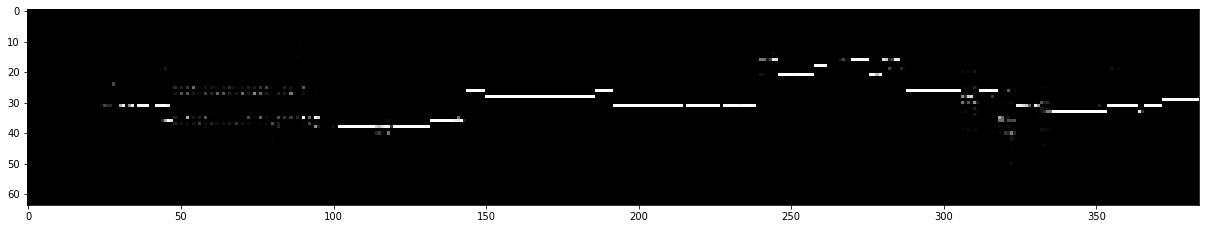

In [17]:
image_paths = glob.glob(os.path.join(save_dir, "fake_samples_*"))
image_paths.sort()

print(f"{len(image_paths)} images found in {save_dir}")
for i, path in enumerate(image_paths):
    print(f"{i}: {path.split('/')[-1]}")

image_path = image_paths[int(input("input the number of image:"))]

img = np.array(Image.open(image_path))
fig, ax = plt.subplots(figsize=(21, 7))
ax.imshow(img)

### 誤差グラフの表示

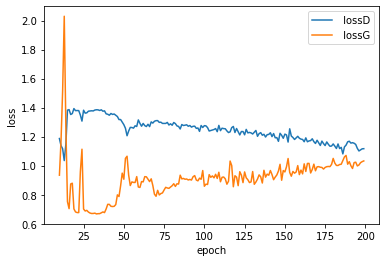

In [18]:
burn_in = 10

lossD_print = np.load(os.path.join(save_dir, 'lossD_list.npy'))[burn_in:]
lossG_print = np.load(os.path.join(save_dir, 'lossG_list.npy'))[burn_in:]

length = lossG_print.shape[0]
x = np.asarray(np.linspace(burn_in, burn_in + length-1, length))
plt.figure()
plt.plot(x, lossD_print,label=' lossD', linewidth=1.5)
plt.plot(x, lossG_print,label=' lossG', linewidth=1.5)
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(os.path.join(save_dir, f'loss_graph_lr={lr}_epoch={epochs}.png'))
plt.show()

midinet2
- 1:10で学習させてもまだDが強いので，新たな[テクニック](https://qiita.com/underfitting/items/a0cbb035568dea33b2d7)を導入
    - midinet2_hacked
        - Gのforwardすべてでlreluを使用
        - DのラベルをSoftNoisyなものに変更(fakeのラベルを[0.0, 0.3], realのラベルを[0.7, 1.2]で一様分布から取得)
        - ノイズを256に増やす(条件ベクトルの10倍くらいのものが使われることが多そうなので512でもいいくらい?)
        - AdamのBeta1を0.9にして学習を加速(?)
        - ノイズを512，学習回数1:16で学習させてみる
            - 学習の記録はGのLossが段々増加，DのLossが段々現象．逆になってほしい…
            - しかし分散は小さかったので，いい線は言っていると思う
            - 生成される音楽は
                - 学習が進むほど空白が多い
                - 鳴っているところも細かい音符が多くて聞き心地が悪い
                - うまくいっている小節はメロディらしくなっているが，あまりうまくいっているものはない
                - 条件にも特に則っているようには思えない
            - とにかく空白が多いのがよくない．
            - 小節の1/3以上が鳴っていない楽譜を削除してみよう
            - 全てlreluにしたのは悪手だったかも．出力が消える．
    - midinet2_dense
        - 9割がon_noteである小節のみを採用したmidinet2_denseデータセットを作成して使用
        - lreluにしたところをF.leruに直した
        - もう少しDに頑張ってほしいのでL1, L2を10倍にした